## Library Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd  
import datetime  # Datetime module for handling dates and times
from binance.client import Client 
from sklearn.preprocessing import StandardScaler  # StandardScaler for feature scaling
from keras.layers import Bidirectional  # Bidirectional layer for bidirectional LSTM
from keras.regularizers import l2  # l2 regulariser for regularisation
from keras.optimizers import Adam  # Adam optimiser for training
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score, r2_score  
from keras.models import Sequential  # Sequential model for building neural networks
from keras.layers import Dense, Activation, Dropout, LSTM  # Layers for neural networks
from datetime import datetime  
import seaborn as sns  

## Binance API Setup

In [ ]:
# Define Binance API keys
api_key = ""    # Binance API key
secret_key = ""  # Binance API secret key

# Initialise Binance client
client = Client(api_key, secret_key)

# Fetch candlestick data from Binance
symbol = 'BTCUSDT'  # Symbol for BTC against USDT
interval = Client.KLINE_INTERVAL_15MINUTE  # Interval for candlestick data
limit = 1000  # Number of data points to fetch
dataset = client.get_klines(symbol=symbol, interval=interval, limit=limit)  # Fetch candlestick data

These lines of code set the correct setting to retrieve Bitcoin candlestick data against USDT via the Binance API. It imports critical libraries for data manipulation, analysis, visualisation and machine learning model development, sets up the Binance client with API credentials and retrieves the necessary data.

## Data Processing

In [2]:
# Extract closing prices and timestamps from candlestick data
closing_prices = np.array([float(data[4]) for data in dataset])  # closing prices for 1000 candles
timestamps = np.array([int(data[0]) for data in dataset])  # Timestamps for 1000 candles
time_strings = np.array([datetime.fromtimestamp(timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S') for timestamp in timestamps])  # Convert timestamps to readable form for 1000 candles

# Create a DataFrame for the candlestick chart
df = pd.DataFrame({'Date': time_strings, 'Close': closing_prices})  # Create df with timestamps and closing prices
df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime format
df.set_index('Date', inplace=True)  # Set 'Date' as index

The closing prices and timestamps are collected from the Binance API's candlestick dataset. The timestamps are then turned into date-time strings that humans can understand. The extracted data is then stored in a pandas DataFrame, which includes columns for the date and closing price. After that, the date column is transformed to datetime format and used as the DataFrame's index.

## Visualisation

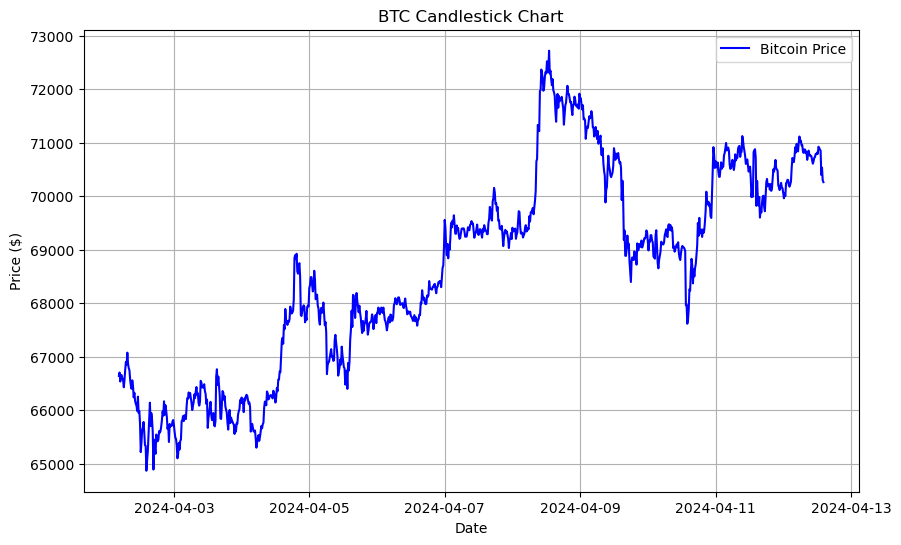

In [3]:
# Plotting the chart
plt.figure(figsize=(10, 6))  
plt.plot(df.index, df['Close'], label='Bitcoin Price', color='blue')  # Closing prices
plt.title('BTC Candlestick Chart')  
plt.xlabel('Date')  
plt.ylabel('Price ($)')  
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()  # Display the plot

In [14]:
# Creating a DF for minute-by-minute price data
price_data = pd.DataFrame({'Time': time_strings, 'Price_BTC': closing_prices})

## Technical Analysis Indicators


In [4]:
# Reshape the price array to a column vector
price = closing_prices.reshape(-1, 1)  

scaler = StandardScaler()  # StandardScaler object for standardising the price 

# Fit the scaler on the first 800 candles for training
scaler.fit(price[:800])  

price_standardised = scaler.transform(price)  # Standardising the price using the fitted scaler

# Reshape the standardised price to have 200 rows and 5 columns
price_reshaped = price_standardised.reshape(200, 5)  

# Import necessary modules for technical analysis indicators
from ta.momentum import RSIIndicator  # Relative Strength Index
from ta.trend import MACD  # Moving Average Convergence Divergence
from ta.trend import SMAIndicator  # Simple Moving Average

# Calculate technical indicators and add them to the DataFrame 
df['RSI'] = RSIIndicator(close=df['Close']).rsi()  # RSI
macd = MACD(close=df['Close'])  # MACD
df['MACD'] = macd.macd()  # line
df['MACD_signal'] = macd.macd_signal()  # Signal line
df['SMA_50'] = SMAIndicator(close=df['Close'], window=50).sma_indicator()  # 50d SMA
df['SMA_200'] = SMAIndicator(close=df['Close'], window=200).sma_indicator()  # 200d SMA

# Remove rows NaN values
df.dropna(inplace=True)

print(df)

                        Close        RSI        MACD  MACD_signal      SMA_50  \
Date                                                                            
2024-04-04 06:15:00  65427.16  37.910589 -156.897208  -124.863349  65865.1024   
2024-04-04 06:30:00  65496.01  41.083910 -151.336051  -130.157890  65849.8272   
2024-04-04 06:45:00  65591.57  45.265259 -137.631372  -131.652586  65840.2986   
2024-04-04 07:00:00  65703.99  49.780749 -116.357661  -128.593601  65834.1390   
2024-04-04 07:15:00  65659.57  48.092491 -101.907687  -123.256418  65828.2902   
...                       ...        ...         ...          ...         ...   
2024-04-12 13:15:00  70852.71  55.110494   35.650741    25.814015  70726.1208   
2024-04-12 13:30:00  70396.69  32.994456   -0.900874    20.471037  70729.2000   
2024-04-12 13:45:00  70534.24  40.721787  -18.555263    12.665777  70734.6846   
2024-04-12 14:00:00  70295.70  33.505412  -51.204425    -0.108263  70734.4432   
2024-04-12 14:15:00  70262.9

This code section involves building a DataFrame employing minute-by-minute price data gathered from the Binance API. The data is broken down into columns for time and Bitcoin prices. Beyond that, the prices are reshaped as a column vector and standardised with StandardScaler, with scaling used for the first 800 candles for training purposes. The standardised prices are then rearranged into a 200x5 array. 

After that, the essential modules for computing technical analysis indicators are imported, such as the Relative Strength Index (RSI), Moving Average Convergence Divergence (MACD), and Simple Moving Averages (SMA). These indicators are calculated and stored in the DataFrame 'df'. RSI, MACD line, signal line, 50-day SMA, and 200-day SMA are all calculated and included in the DataFrame. 

Finally, any rows with NaN values are deleted from the DataFrame and the final DataFrame is shown.

## Data Splitting


In [5]:
# Split train and test data
train_samples = 150  # Number of samples for training
test_samples = 50  # Number of samples for testing

# Features and target column for training data
x_train = df.iloc[:train_samples, :-1]
y_train = df.iloc[:train_samples, -1]

# Features and target column for testing data
x_test = df.iloc[train_samples:train_samples + test_samples, :-1]
y_test = df.iloc[train_samples:train_samples + test_samples, -1]

## Data Preparation for LSTM

In [6]:
# Reshape input data for LSTM model
x_train = np.array(x_train).reshape((x_train.shape[0], x_train.shape[1], 1))  
x_test = np.array(x_test).reshape((x_test.shape[0], x_test.shape[1], 1))  

In [7]:
# Printing the shape of train and test data
print("Shape of training data (x_train):", x_train.shape)
print("Shape of testing data (x_test):", x_test.shape)

Shape of training data (x_train): (150, 5, 1)
Shape of testing data (x_test): (50, 5, 1)


This code paragraph separates the dataset into training and test sets. It provides the amount of samples for each set, extracts the features and target columns, reshapes the input data to be LSTM compatible, then releases the shapes of the generated arrays for verification.

## Model Definition


In [8]:
# Set random seed for reproducibility
np.random.seed(42)
# Define the model architecture
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), kernel_regularizer=l2(0.001))),
    Dropout(0.3),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    LSTM(32, kernel_regularizer=l2(0.001)),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Build the model
model.build(input_shape=(None, x_train.shape[1], x_train.shape[2]))

# Printing the model summary
print("Model Summary:")
model.summary()

Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 256)           133120    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 5, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 64)             82176     
                                                                 
 dropout_1 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                         

This block of code generates a random seed for reproducibility, defines the architecture of a sequential neural network model with LSTM layers and regularisation, compiles the model with the Adam optimizer and mean squared error loss function, builds the model based on the input shape and displays a summary of the model architecture.

## Model Training


In [9]:
# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), verbose=1)

Epoch 1/100
5/5 [==============================] - 8s 441ms/step - loss: 4410058752.0000 - val_loss: 4516316160.0000
Epoch 2/100
5/5 [==============================] - 0s 29ms/step - loss: 4409978368.0000 - val_loss: 4516225536.0000
Epoch 3/100
5/5 [==============================] - 0s 26ms/step - loss: 4409892864.0000 - val_loss: 4516135424.0000
Epoch 4/100
5/5 [==============================] - 0s 32ms/step - loss: 4409808384.0000 - val_loss: 4516041728.0000
Epoch 5/100
5/5 [==============================] - 0s 29ms/step - loss: 4409716736.0000 - val_loss: 4515945472.0000
Epoch 6/100
5/5 [==============================] - 0s 31ms/step - loss: 4409622528.0000 - val_loss: 4515850752.0000
Epoch 7/100
5/5 [==============================] - 0s 30ms/step - loss: 4409529856.0000 - val_loss: 4515761152.0000
Epoch 8/100
5/5 [==============================] - 0s 30ms/step - loss: 4409442816.0000 - val_loss: 4515682304.0000
Epoch 9/100
5/5 [==============================] - 0s 29ms/step - loss:

This line of code trains the given model ('model') using the training data ('x_train' and 'y_train') for 100 epochs with a batch size of 32. It additionally offers the validation data that will be used to evaluate the model's performance during training using the test data ('x_test' and 'y_test'). The training progress is shown ('verbose=1'). The training history, containing loss and other metrics, is saved in the 'history' variable for further analysis or visualisation.

## Evaluation of Model

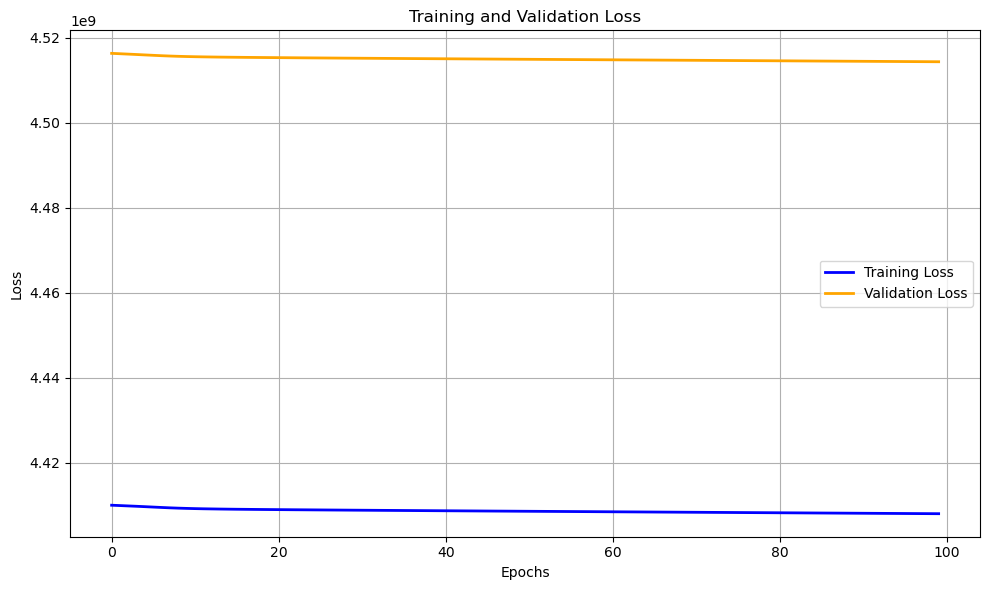

In [10]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))  # Adjust the figure size for better visibility

plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Change layout to prevent overlap
plt.show()

In [11]:
# Evaluate model on test data
test_loss = model.evaluate(x_test, y_test, verbose=1)

# Print test loss
print('Test Loss:', test_loss)

# Get predictions from model
y_pred = model.predict(x_test)

# Convert y_test to a numpy array and reshape
y_test = np.array(y_test).reshape(-1, 1)

# Reshape y_pred to have the same shape as y_test
y_pred = y_pred.reshape(-1, 1)

# Inverse transform to get the original scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Calculate RMSE and Rsquared
test_score = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r_squared = r2_score(y_test_inv, y_pred_inv)

# Print the evaluation 
print('Test Score (RMSE): {:.2f}'.format(test_score))
print('R-squared: {:.2f}%'.format(r_squared * 100))

2/2 [==============================] - 0s 14ms/step - loss: 4514340352.0000
Test Loss: 4514340352.0
2/2 [==============================] - 2s 7ms/step
Test Score (RMSE): 126371042.80
R-squared: -25777351.48%


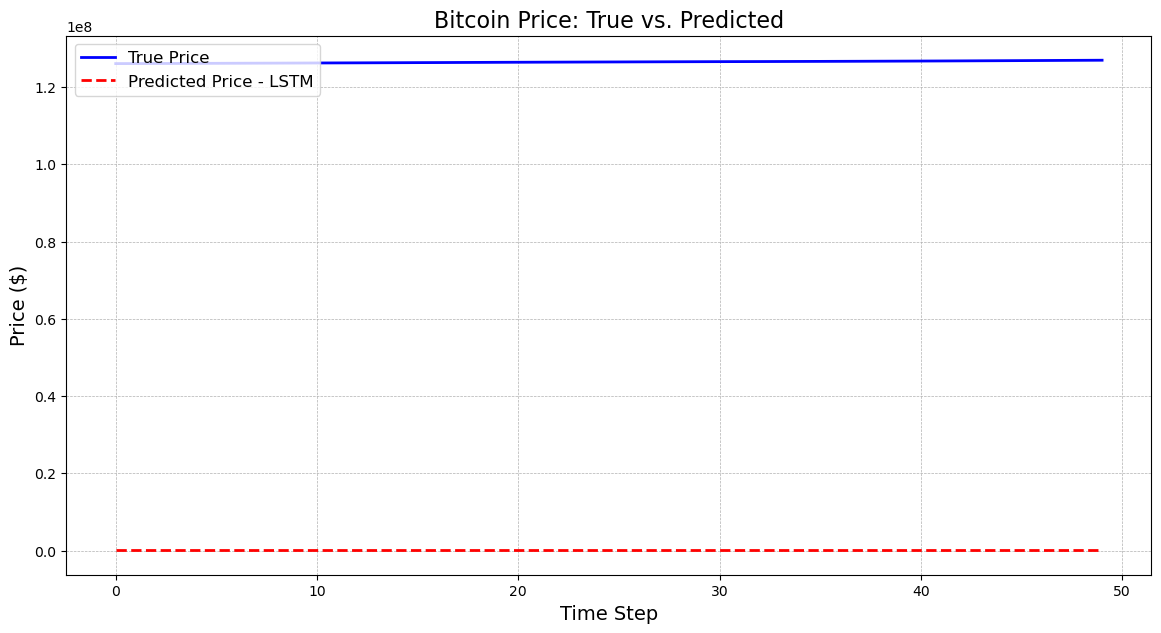

In [12]:
plt.figure(figsize=(14, 7))  

# Plotting the true and predicted prices
plt.plot(y_test_inv, label='True Price', color='blue', linewidth=2)
plt.plot(y_pred_inv, label='Predicted Price - LSTM', color='red', linewidth=2, linestyle='--')

plt.title('Bitcoin Price: True vs. Predicted', fontsize=16)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Grid helps in seeing of data points

plt.show()

These code blocks assess the training model against the test data. It predicts the model's loss (mean squared error) on the test information and generates it. It then employs the training model to predict Bitcoin values based on test characteristics ('x_test'). 

The scaler converts predictions ('y_pred') and true prices ('y_test') back to their original scale. 

Following transformation, it computes the root mean squared error (RMSE) and R-squared score between the true and projected prices and publishes these evaluation metrics. 

Finally, it graphs the real and forecasted prices versus time steps to show the model's performance.

___

## Analysis of Model Performance

### Reasons for Low Accuracy

1. The 'StandardScaler' employed for data normalisation may not be optimal for financial time series such as bitcoin prices, which are subject to considerable volatility and outliers. These traits may have a negative impact on the normalisation process, perhaps resulting in inferior model performance.

2. The model included bidirectional LSTM layers as well as numerous dropout layers. Although capable of identifying complex patterns in data, this complexity may result in overfitting, particularly if the training data is insufficiently diverse or contains significant noise.

3. Extremely high RMSE and significantly negative R-squared values indicate that the model's predictions are seriously incorrect performing worse than a simple baseline model that predicts average values.

4. The selected features, such as RSI, MACD and SMA, could fail to properly represent the predictive elements required to accurately forecast future prices, consequently resulting in poor prediction performance.

### Ineffectiveness of Technical Indicators

1. Because they are based on previous price data, technical indicators such as RSI, MACD and SMA are always behind. As a result, they could not pick up new patterns as soon as they should in the extremely unpredictable bitcoin market.

2. A significant reliance on past patterns using technical indicators could lead the model to overfit to previous information. This overfitting might impair the model's ability to anticipate future movements, particularly when these movements do not follow previous trends.

3. Technical indicators give an understanding of features such as momentum and trend strength, but they do not take into account external variables that impact price movements, such as market emotion, economic indicators or geopolitical events. This constraint may result in underperformance in predictive modelling.


_____

## References

- Harris, Charles, Millman, K. Jarrod, van der Walt, Stéfan et al. (2020). *Array programming with NumPy*. Nature, 585(7825), 357-362. [https://doi.org/10.1038/s41586-020-2649-2](https://doi.org/10.1038/s41586-020-2649-2)
- Hunter, J. D. (2007). *Matplotlib: A 2D graphics environment*. Computing in Science & Engineering, 9(3), 90-95. [https://doi.org/10.1109/MCSE.2007.55](https://doi.org/10.1109/MCSE.2007.55)
- McKinney, Wes. (2010). *Data Structures for Statistical Computing in Python*. Proceedings of the 9th Python in Science Conference, 51-56. [https://conference.scipy.org/proceedings/scipy2010/mckinney.html](https://conference.scipy.org/proceedings/scipy2010/mckinney.html)
- Binance API documentation. [https://binance-docs.github.io/apidocs/spot/en/](https://binance-docs.github.io/apidocs/spot/en/)
- Pedregosa et al. (2011). *Scikit-learn: Machine Learning in Python*. Journal of Machine Learning Research, 12, 2825-2830. [http://jmlr.org/papers/v12/pedregosa11a.html](http://jmlr.org/papers/v12/pedregosa11a.html)
- Chollet François et al. (2015). *Keras*. [https://keras.io](https://keras.io)
- Waskom, Michael et al. (2020). *Seaborn: statistical data visualization*. Journal of Open Source Software, 6(60), 3021. [https://doi.org/10.21105/joss.03021](https://doi.org/10.21105/joss.03021)
- Bukoski, B. J., & DeNero, J. (2021). *The pedagogy of teaching machine learning with scikit-learn*. Proceedings of the 52nd ACM Technical Symposium on Computer Science Education, 1-7. [https://doi.org/10.1145/3408877.3432394](https://doi.org/10.1145/3408877.3432394)
